In [25]:
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler
from arch import arch_model

import warnings
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)

In [ ]:
df = pd.read_parquet('data/v80/final_matrix_tha_perp_labeled_v80.parquet')[['Time', 'Epoch_time', 'Bx', 'By', 'Bz', '|V_perp|', 'Event_label']]
event_df = pd.read_csv('data/event_data_all_perp_80_avg.csv').query("satellite_name == 'THEMIS A'").reset_index(drop=True)

X = df[['Bx', 'By', 'Bz']].values
y = df['Event_label'].values

In [ ]:
# Gets indices of continuous sequences by checking if the timestep difference is > 300 (5 minutes)
continuous_sequences = df.groupby((df['Epoch_time'].diff() > 300).cumsum()).apply(lambda x: list(x.index)).values

In [ ]:
# Gets all event interval indices
tha_start_time = (pd.to_datetime(event_df['start_time']).astype('int64') / 10**9).values
tha_end_time = (pd.to_datetime(event_df['end_time']).astype('int64') / 10**9).values

event_indices = []

for idx, row in event_df.iterrows():
    start_idx = np.searchsorted(df['Epoch_time'], tha_start_time[idx], side='left')
    end_idx = np.searchsorted(df['Epoch_time'], tha_end_time[idx], side='right')

    event_indices.append(df.iloc[start_idx:end_idx].index.values)

In [ ]:
sampled_sequences = random.sample([seq for seq in continuous_sequences], min(10, len(continuous_sequences)))

In [ ]:
# Finds numbers in the list of lists
def find_number(lists, target):
    for index, sublist in enumerate(lists):
        if target in sublist:
            return index, sublist
    return None 

result_end = find_number(continuous_sequences, 12922982)
result_1 = find_number(continuous_sequences, 18493042)
result_2 = find_number(continuous_sequences, 5226436)

print(result_1)
print(result_2)
print(result_end)

(1426, [18485224, 18485225, 18485226, 18485227, 18485228, 18485229, 18485230, 18485231, 18485232, 18485233, 18485234, 18485235, 18485236, 18485237, 18485238, 18485239, 18485240, 18485241, 18485242, 18485243, 18485244, 18485245, 18485246, 18485247, 18485248, 18485249, 18485250, 18485251, 18485252, 18485253, 18485254, 18485255, 18485256, 18485257, 18485258, 18485259, 18485260, 18485261, 18485262, 18485263, 18485264, 18485265, 18485266, 18485267, 18485268, 18485269, 18485270, 18485271, 18485272, 18485273, 18485274, 18485275, 18485276, 18485277, 18485278, 18485279, 18485280, 18485281, 18485282, 18485283, 18485284, 18485285, 18485286, 18485287, 18485288, 18485289, 18485290, 18485291, 18485292, 18485293, 18485294, 18485295, 18485296, 18485297, 18485298, 18485299, 18485300, 18485301, 18485302, 18485303, 18485304, 18485305, 18485306, 18485307, 18485308, 18485309, 18485310, 18485311, 18485312, 18485313, 18485314, 18485315, 18485316, 18485317, 18485318, 18485319, 18485320, 18485321, 18485322, 18

In [ ]:
# Tanh function to standardize the data
def tanh_squash(x, scale=1.0):
    return np.tanh(x / scale)

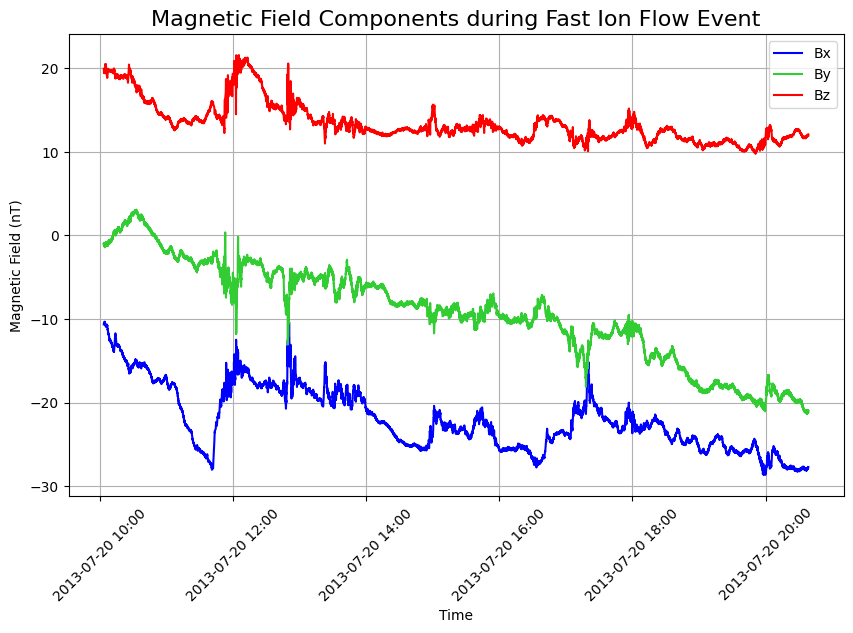

In [ ]:
# Plots the magnetic field components of the first continuous sequence
for sequence in continuous_sequences[:1]:
    continuous_df = df.loc[sequence[0]:sequence[-1], ['Time', 'Bx', 'By', 'Bz', '|V_perp|']]

    # Uses local outlier factor to filter out anomalies
    lof = LocalOutlierFactor(n_neighbors=29, contamination="auto")
    outlier_flags = lof.fit_predict(continuous_df[['Bx', 'By', 'Bz']])
    continuous_df.loc[outlier_flags == -1, ['Bx', 'By', 'Bz']] = np.nan
    continuous_df[['Bx', 'By', 'Bz']] = continuous_df[['Bx', 'By', 'Bz']].interpolate().bfill()

    
    plt.figure(figsize=(10, 6), dpi=100)
    plt.plot(continuous_df['Time'], continuous_df['Bx'], label='Bx', color='blue')
    plt.plot(continuous_df['Time'], continuous_df['By'], label='By', color='limegreen')
    plt.plot(continuous_df['Time'], continuous_df['Bz'], label='Bz', color='red')
    plt.legend()
    plt.grid()

    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
    plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
    plt.xlabel("Time")
    plt.xticks(rotation=45)
    plt.ylabel("Magnetic Field (nT)")
    plt.title("Magnetic Field Components during Fast Ion Flow Event", fontsize=16)
    plt.show()

In [ ]:
idx = 0

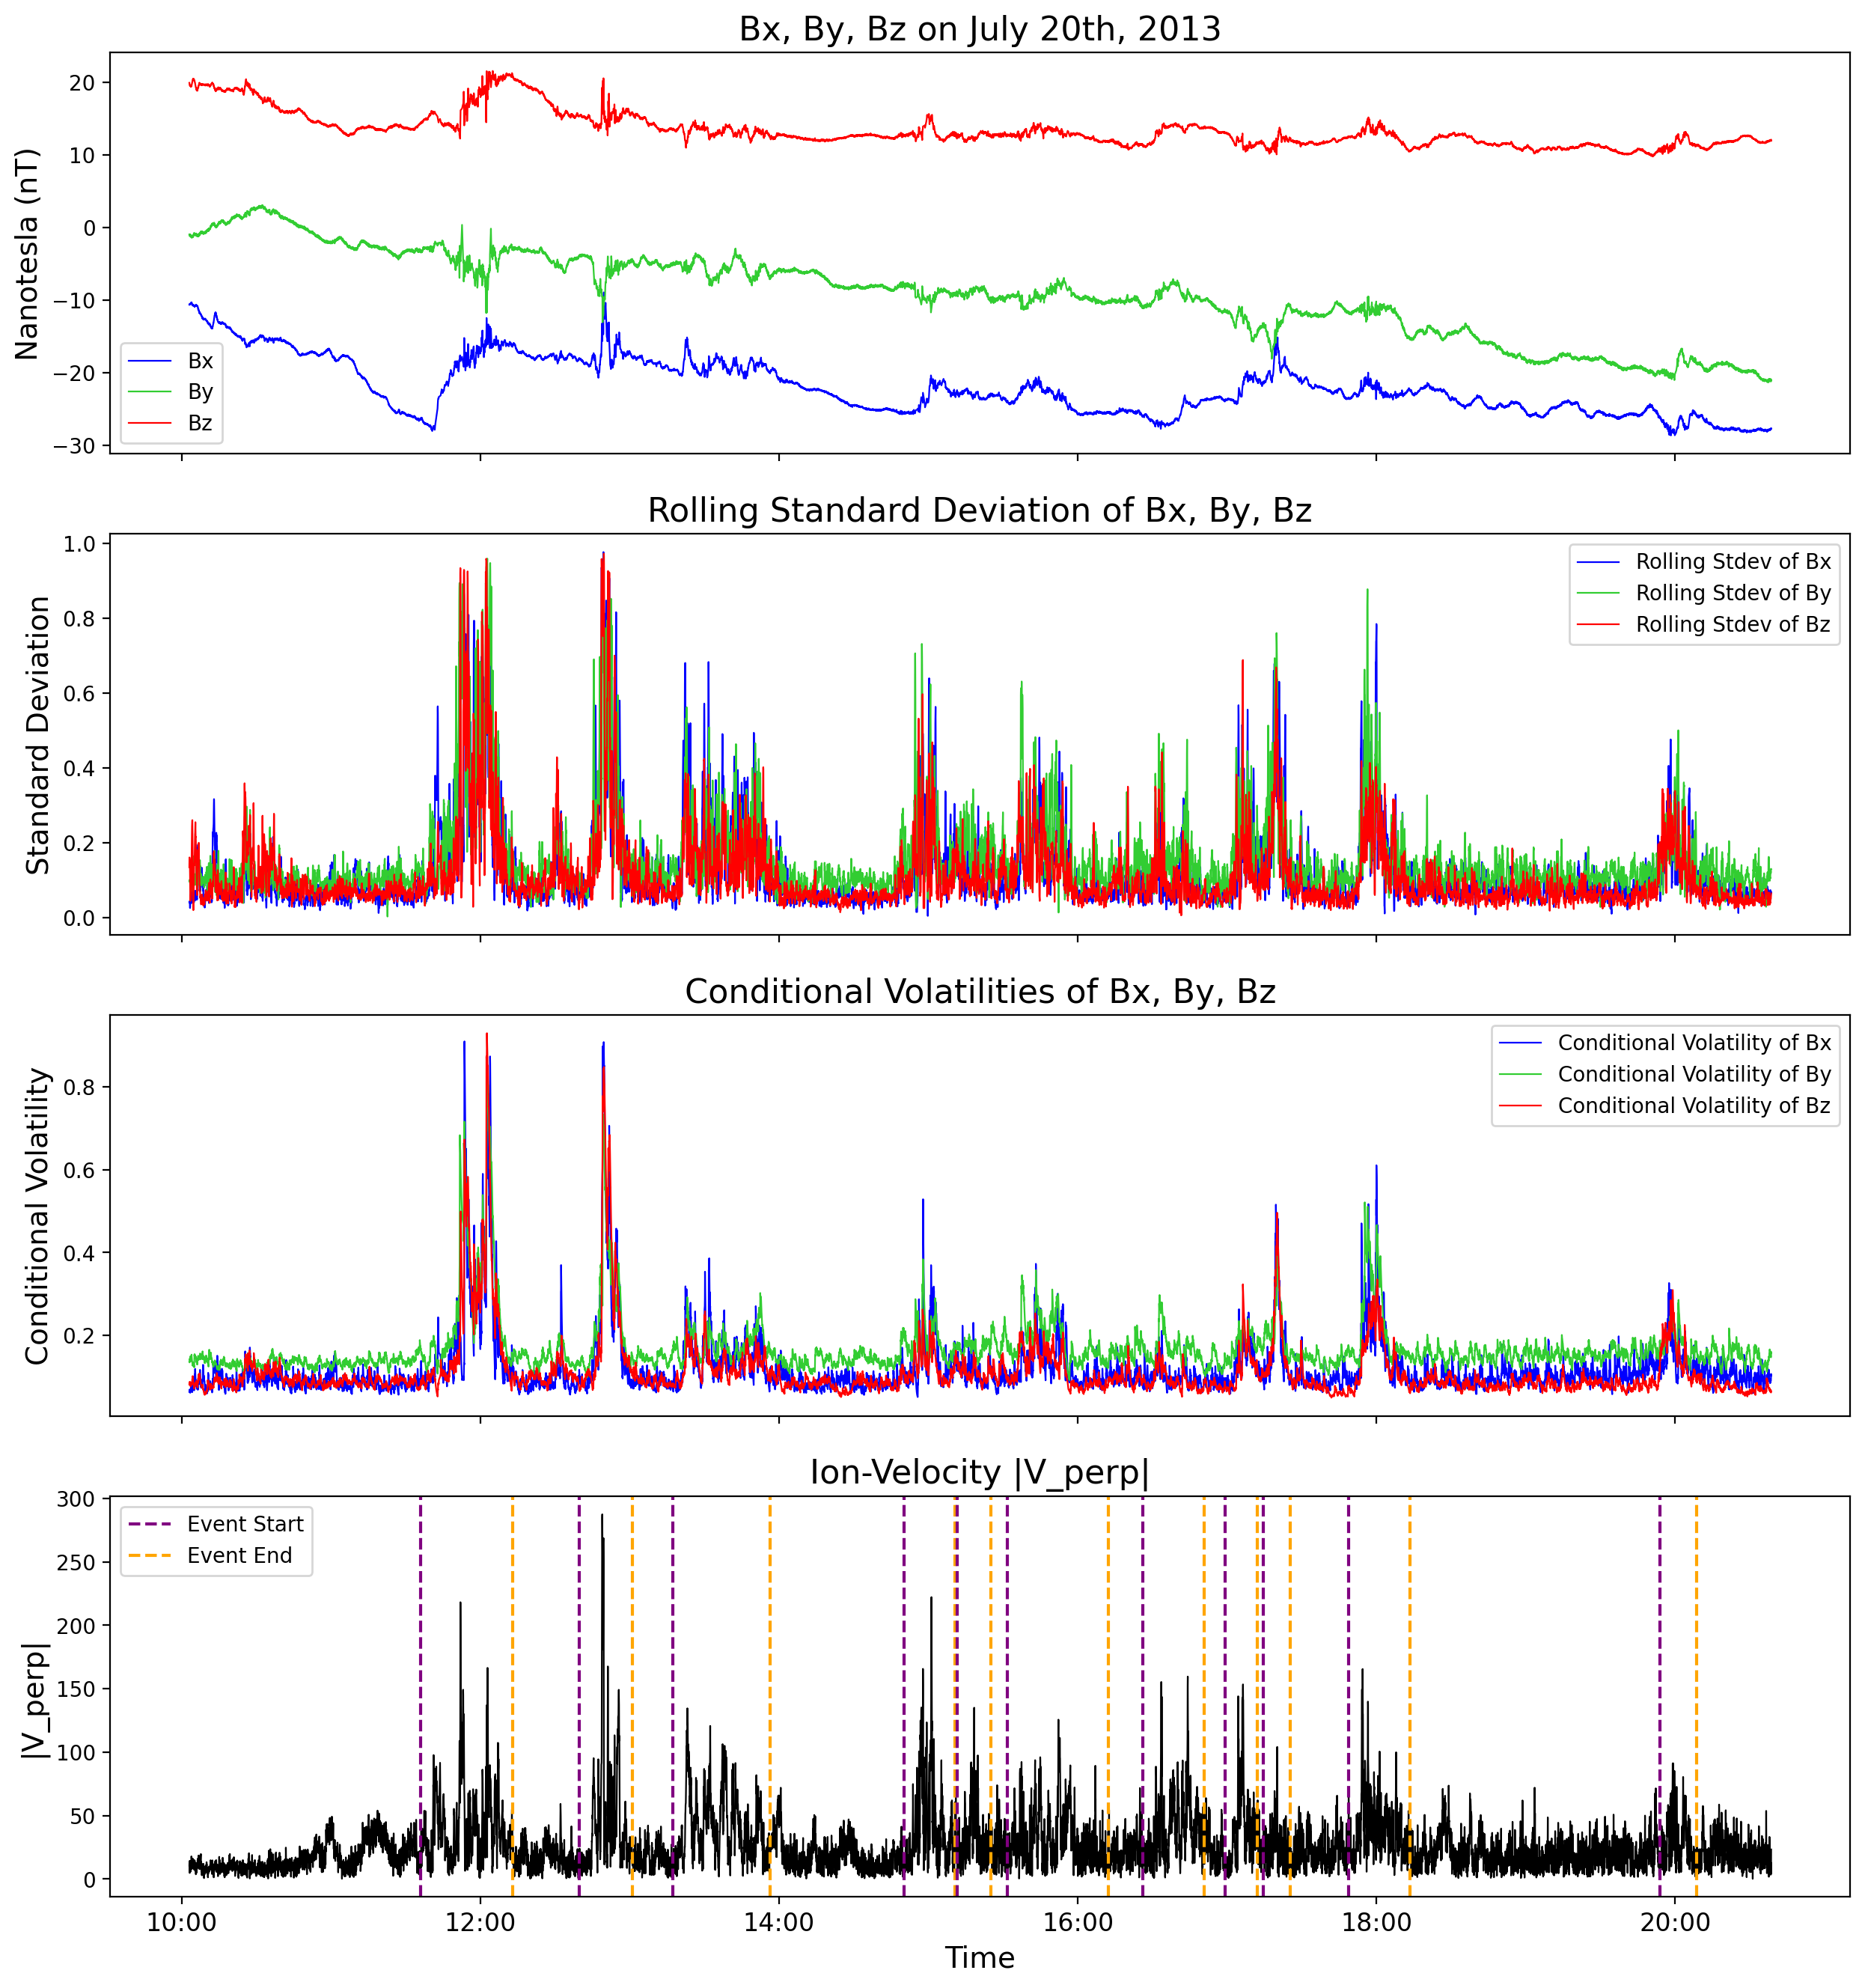

In [ ]:
# Plots the mag field, volatilites, and rolling standard deviations, garch volatilities, and ion-velocity
continuous_df = df.loc[continuous_sequences[idx][0]:continuous_sequences[idx][-1], ['Time', 'Bx', 'By', 'Bz', '|V_perp|']].copy()

# local outlier factor to filter out anomalies
lof = LocalOutlierFactor(n_neighbors=29, contamination='auto')
outlier_flags = lof.fit_predict(continuous_df[['Bx', 'By', 'Bz']])
continuous_df.loc[outlier_flags == -1, ['Bx', 'By', 'Bz']] = np.nan
continuous_df[['Bx', 'By', 'Bz']] = continuous_df[['Bx', 'By', 'Bz']].interpolate().bfill()

# Fit an AR(1)-GARCH(1, 1) model to get conditional volatility of magnetic field components
# Multiply input by 10 for numerical stability
model_bx = arch_model(continuous_df['Bx'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)
model_by = arch_model(continuous_df['By'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)
model_bz = arch_model(continuous_df['Bz'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)

model_bx_fit = model_bx.fit(disp="off", show_warning=False)
model_by_fit = model_by.fit(disp="off", show_warning=False)
model_bz_fit = model_bz.fit(disp="off", show_warning=False)

# Scale the output to be between 0 and 1
bx_conditional_vol = tanh_squash(model_bx_fit.conditional_volatility.bfill(), scale=10)
by_conditional_vol = tanh_squash(model_by_fit.conditional_volatility.bfill(), scale=10)
bz_conditional_vol = tanh_squash(model_bz_fit.conditional_volatility.bfill(), scale=10)

# Computes a 9-window rolling stdev to capture local volatility of the mag field components
continuous_df[['Bx_rolling_stdev', 'By_rolling_stdev', 'Bz_rolling_stdev']] = continuous_df[['Bx', 'By', 'Bz']].rolling(window=9, min_periods=1, center=True).std()

fig, (ax0, ax1, ax2, ax3) = plt.subplots(4, 1, figsize=(15, 16), sharex=True, dpi=200)

ax0.plot(continuous_df['Time'], continuous_df['Bx'], label='Bx', lw=0.8, color='blue')
ax0.plot(continuous_df['Time'], continuous_df['By'], label='By', lw=0.8, color='limegreen')
ax0.plot(continuous_df['Time'], continuous_df['Bz'], label='Bz', lw=0.8, color='red')
ax0.set_ylabel('Nanotesla (nT)', fontsize=14)
ax0.legend(loc='best')

ax1.plot(continuous_df['Time'], tanh_squash(continuous_df['Bx_rolling_stdev'], scale=1.0), label='Rolling Stdev of Bx', lw=0.8, color='blue')
ax1.plot(continuous_df['Time'], tanh_squash(continuous_df['By_rolling_stdev'], scale=1.0), label='Rolling Stdev of By', lw=0.8, color='limegreen')
ax1.plot(continuous_df['Time'], tanh_squash(continuous_df['Bz_rolling_stdev'], scale=1.0), label='Rolling Stdev of Bz', lw=0.8, color='red')
ax1.set_ylabel('Standard Deviation', fontsize=14)
ax1.set_title(f"Rolling Standard Deviation of Bx, By, Bz", fontsize=16)
ax1.legend(loc='best')

ax2.plot(continuous_df['Time'], bx_conditional_vol, label='Conditional Volatility of Bx', lw=0.8, color='blue')
ax2.plot(continuous_df['Time'], by_conditional_vol, label='Conditional Volatility of By', lw=0.8, color='limegreen')
ax2.plot(continuous_df['Time'], bz_conditional_vol, label='Conditional Volatility of Bz', lw=0.8, color='red')
ax2.set_ylabel('Conditional Volatility', fontsize=14)
ax2.set_title("Conditional Volatilities of Bx, By, Bz", fontsize=16)
ax2.legend(loc='best')

ax3.plot(continuous_df['Time'], continuous_df['|V_perp|'], lw=0.8, color='black')
ax3.set_ylabel('|V_perp|', fontsize=14)
ax3.set_xlabel('Time', fontsize=14)
ax3.set_title('Ion-Velocity |V_perp|', fontsize=16)

start_times = pd.to_datetime(tha_start_time, unit='s', utc=True)
end_times = pd.to_datetime(tha_end_time, unit='s', utc=True)
event_ids = event_df['event_id'].astype(str)

event_start_plotted = False
event_end_plotted = False

for start, end in zip(start_times, end_times):
    if continuous_df['Time'].min() <= start <= continuous_df['Time'].max() or continuous_df['Time'].min() <= end <= continuous_df['Time'].max():
        ax3.axvline(
            start, color='purple', linestyle='--', lw=1.5,
            label="Event Start" if not event_start_plotted else None
        )
        ax3.axvline(
            end, color='orange', linestyle='--', lw=1.5,
            label="Event End" if not event_end_plotted else None
        )
        event_start_plotted = True
        event_end_plotted = True

ax3.legend()

event_ids = list(event_df[(pd.to_datetime(event_df['start_time']) >= continuous_df.iloc[0, 0]) &
                          (pd.to_datetime(event_df['end_time']) <= continuous_df.iloc[-1, 0])]
                          ['event_id'])

ax0.set_title(f"Bx, By, Bz on July 20th, 2013", fontsize=16)
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
plt.gca().xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=8))
plt.xticks(fontsize=12)
plt.show()

In [ ]:
# Correlation of the features and ion-velocity
print(pd.DataFrame({
    'CV bx': bx_conditional_vol,
    'CV by': by_conditional_vol,
    'CV bz': bz_conditional_vol,
    'Bx': tanh_squash(continuous_df['Bx_rolling_stdev'], scale=10),
    'By': tanh_squash(continuous_df['By_rolling_stdev'], scale=10),
    'Bz': tanh_squash(continuous_df['Bz_rolling_stdev'], scale=10),
    '|V_perp|': MinMaxScaler().fit_transform(tanh_squash(continuous_df[['|V_perp|']], scale=100)).reshape(1, -1)[0]
}).corr())

             CV bx     CV by     CV bz        Bx        By        Bz  |V_perp|
CV bx     1.000000  0.255574  0.740762  0.772281  0.629233  0.613777  0.287791
CV by     0.255574  1.000000  0.324890  0.221018  0.439058  0.255596  0.024730
CV bz     0.740762  0.324890  1.000000  0.550708  0.636654  0.684795  0.020227
Bx        0.772281  0.221018  0.550708  1.000000  0.572430  0.571357  0.309745
By        0.629233  0.439058  0.636654  0.572430  1.000000  0.615233  0.209085
Bz        0.613777  0.255596  0.684795  0.571357  0.615233  1.000000  0.158518
|V_perp|  0.287791  0.024730  0.020227  0.309745  0.209085  0.158518  1.000000


In [ ]:
# Iterate through all continuous sequences, and generate the necessary features
# MinMaxScaled magnetic field components
# Tanh squashed rolling stdevs
# Tanh squashed garch volatilities

bx_volatilities = []
by_volatilities = []
bz_volatilities = []

bx_rolling_stdevs = []
by_rolling_stdevs = []
bz_rolling_stdevs = []

bx_new = []
by_new = []
bz_new = []

for sequence in continuous_sequences:
    continuous_df = df.loc[sequence[0]:sequence[-1], ['Bx', 'By', 'Bz', '|V_perp|']].copy()
    
    lof = LocalOutlierFactor(n_neighbors=29, contamination="auto")
    outlier_flags = lof.fit_predict(continuous_df[['Bx', 'By', 'Bz']])
    continuous_df.loc[outlier_flags == -1, ['Bx', 'By', 'Bz']] = np.nan
    continuous_df[['Bx', 'By', 'Bz']] = continuous_df[['Bx', 'By', 'Bz']].interpolate().bfill()
    
    model_bx = arch_model(continuous_df['Bx'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)
    model_by = arch_model(continuous_df['By'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)
    model_bz = arch_model(continuous_df['Bz'].copy() * 10, mean='AR', lags=1, vol='GARCH', p=1, q=1, rescale=False)

    model_bx_fit = model_bx.fit(disp="off", show_warning=False)
    model_by_fit = model_by.fit(disp="off", show_warning=False)
    model_bz_fit = model_bz.fit(disp="off", show_warning=False)
    
    bx_conditional_vol = tanh_squash(model_bx_fit.conditional_volatility.bfill(), scale=10)
    by_conditional_vol = tanh_squash(model_by_fit.conditional_volatility.bfill(), scale=10)
    bz_conditional_vol = tanh_squash(model_bz_fit.conditional_volatility.bfill(), scale=10)

    continuous_df[['Bx_rolling_stdev', 'By_rolling_stdev', 'Bz_rolling_stdev']] = continuous_df[['Bx', 'By', 'Bz']].rolling(window=9, min_periods=1, center=True).std()
    bx_rolling_stdev = tanh_squash(continuous_df['Bx_rolling_stdev'], scale=1.0)
    by_rolling_stdev = tanh_squash(continuous_df['By_rolling_stdev'], scale=1.0)
    bz_rolling_stdev = tanh_squash(continuous_df['Bz_rolling_stdev'], scale=1.0)

    continuous_df[['Bx', 'By', 'Bz']] = MinMaxScaler().fit_transform(continuous_df[['Bx', 'By', 'Bz']].copy())

    bx_volatilities.extend(bx_conditional_vol)
    by_volatilities.extend(by_conditional_vol)
    bz_volatilities.extend(bz_conditional_vol)
    
    bx_rolling_stdevs.extend(bx_rolling_stdev)
    by_rolling_stdevs.extend(by_rolling_stdev)
    bz_rolling_stdevs.extend(bz_rolling_stdev)

    bx_new.extend(continuous_df['Bx'].values)
    by_new.extend(continuous_df['By'].values)
    bz_new.extend(continuous_df['Bz'].values)

In [ ]:
# Create the final model dataframe
final_model_df = df[['Epoch_time']].copy()

final_model_df["Bx"] = bx_new
final_model_df["By"] = by_new
final_model_df["Bz"] = bz_new

# Generate 2 lags for magnetic field components based on VAR results in 6-2_event_patterns
num_lags = 2
for col in ['Bx', 'By', 'Bz']:
    for lag in range(1, num_lags + 1):
        final_model_df[f"{col}_lag_{lag}"] = final_model_df[col].shift(lag)

final_model_df["Bx_conditional_vol"] = bx_volatilities
final_model_df["By_conditional_vol"] = by_volatilities
final_model_df["Bz_conditional_vol"] = bz_volatilities

final_model_df['Bx_rolling_stdev'] = bx_rolling_stdevs
final_model_df['By_rolling_stdev'] = by_rolling_stdevs
final_model_df['Bz_rolling_stdev'] = bz_rolling_stdevs

final_model_df['Event_label_80'] = df['Event_label'].copy()

In [ ]:
# Drop first 2 rows and reset index
final_model_df = final_model_df.dropna().reset_index(drop=True)
final_model_df['Event_label_100'] = pd.read_parquet("data/v100/final_model_data_perp_tha.parquet")['Event_label']

In [30]:
final_model_df

,Epoch_time,Bx,By,Bz,Bx_lag_1,Bx_lag_2,By_lag_1,By_lag_2,Bz_lag_1,Bz_lag_2,Bx_conditional_vol,By_conditional_vol,Bz_conditional_vol,Bx_rolling_stdev,By_rolling_stdev,Bz_rolling_stdev,Event_label_80,Event_label_100
0,1.199000e+09,0.726732,0.486723,0.518160,0.714356,0.716737,0.400342,0.468074,0.549437,0.526513,0.056211,0.276772,0.134117,0.049056,0.223092,0.085817,0,0
1,1.199000e+09,0.723216,0.424164,0.563470,0.726732,0.714356,0.486723,0.400342,0.518160,0.549437,0.058123,0.315444,0.142369,0.051894,0.211136,0.087391,0,0
2,1.199000e+09,0.733366,0.491934,0.550957,0.723216,0.726732,0.424164,0.486723,0.563470,0.518160,0.058015,0.282979,0.165417,0.048650,0.199964,0.084355,0,0
3,1.199000e+09,0.735368,0.514985,0.527027,0.733366,0.723216,0.491934,0.424164,0.550957,0.563470,0.059140,0.285706,0.156932,0.043547,0.200193,0.092545,0,0
4,1.199000e+09,0.735268,0.504930,0.542089,0.735368,0.733366,0.514985,0.491934,0.527027,0.550957,0.058908,0.233592,0.155196,0.032806,0.157112,0.092607,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16721131,1.735691e+09,0.484599,0.307891,0.167793,0.489673,0.496716,0.318610,0.313656,0.174733,0.171560,0.258150,0.283005,0.137505,0.278526,0.113335,0.050747,1,1
16721132,1.735691e+09,0.486628,0.312221,0.170451,0.484599,0.489673,0.307891,0.318610,0.167793,0.174733,0.258458,0.298117,0.147115,0.269687,0.120514,0.054202,1,1
16721133,1.735691e+09,0.486121,0.311177,0.169681,0.486628,0.484599,0.312221,0.307891,0.170451,0.167793,0.251662,0.289892,0.141548,0.263129,0.113923,0.052578,1,1
16721134,1.735691e+09,0.487642,0.314432,0.171653,0.486121,0.486628,0.311177,0.312221,0.169681,0.170451,0.244133,0.280034,0.135552,0.193817,0.124187,0.057109,1,1


In [ ]:
final_model_df.to_parquet('data/final_model_data_tha_scaled.parquet', index=False)